# Data Science Task 2

This is a segmentation task that uses company sales data as the data basis. In this task, customers are to be divided into segments based on their purchasing behavior (customer segmentation). The main task is to identify relevant patterns in the purchasing behavior of customers. Several segmentation solutions are possible. The ones of particular importance to the company are those that are associated with a gain in customer insight, with implications for revenue and profit growth.

In general, a customer segmentation is carried out so that customers can be addressed in a targeted manner or in order to offer suitable products and services to the customer. **Meaningful** differentiation criteria for the company would be the customer price sensitivity, the assortment mix (similarity of the articles purchased by the customer), seasonal buying behavior of the customer, etc.

## Goal of this task

Write a small program that divides customers into customer groups based on their purchasing behavior. Use a suitable, respectively preferred programming language (Python, Matlab, R) or library. You are welcome to use notebooks (e.g., Jupyter Notebook) for the purpose of writing and documenting your code.

For this task several solutions are possible. Therefore, it is important to document the program code. A logging of a progress, function and error report provides extra points in evaluation.
Use company sales data as data basis.

# Scores:

- Final segmentation of customers. The code should be clean, understandable and sufficiently commented. (**50 points**)

- Adequate comments and user instructions. All necessary means (e.g. extra libraries to be installed) to run the program (**10 points**).

- Graphical representation and interpretation of the final solution (your created customer segmentation) (**15 points**)

- Logging of your progress, function and error report (**25 points**)

Total **100 points**

In [61]:
%matplotlib inline
import os
import glob
import numpy as np
import seaborn as sns

from datetime import datetime
import locale
locale.setlocale(locale.LC_ALL, "german")

from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

# 1. Data Cleaning & Exploratory Data Analysis

## Import Modules, Load Data & Data Review

In [113]:
### Import factura data as data frame ###
# The file "DataScienceAufgabe2_FacturaData" is located in folder "/DataScienceAufgabe2/Data/".
# In order to use it in jupyter notebook you have to upload it (See "Upload" Button in http://localhost:8889/tree) )

factura_df = pd.read_csv("DataScienceAufgabe2_FacturaData.csv", encoding="iso-8859-1", decimal=",", sep=";")
# Get column overview
factura_df.dtypes

customerNumber                           int64
purchaseDate                            object
branchNumber                             int64
articleNumber                            int64
quantity                               float64
discountOnRecommendedRetailPrice[%]    float64
purchaseAmount                         float64
dtype: object

In [114]:
factura_df.head()

,customerNumber,purchaseDate,branchNumber,articleNumber,quantity,discountOnRecommendedRetailPrice[%],purchaseAmount
0,557,2021-01-04,19,6013,1.00,0.00,17.24
1,557,2021-01-04,19,6663,2.00,8.37,94.96
2,189,2021-01-04,17,2982,2.00,32.23,59.96
3,490,2021-01-04,19,10658,1.00,25.04,24.05
4,896,2021-01-04,36,14971,3.00,0.00,26.69


In [115]:
factura_df.describe().T

,count,mean,std,min,25%,50%,75%,max
customerNumber,718987.00,509.37,287.25,1.00,253.00,522.00,746.00,1000.00
branchNumber,718987.00,48.62,29.36,1.00,25.00,42.00,74.00,101.00
articleNumber,718987.00,10418.54,6267.80,1.00,4730.00,10207.00,15982.00,21088.00
quantity,718987.00,15.63,89.42,0.00,1.00,2.00,6.00,13013.00
discountOnRecommendedRetailPrice[%],718987.00,3.53,10.93,0.00,0.00,0.00,0.00,100.00
purchaseAmount,718987.00,123.19,244.96,0.03,21.29,51.96,128.63,24728.52


Here we can roughly analyze the data distribution. There are no negative values for quantity in the data set. It can be concluded that the data set does not indicate order cancellation. 

In [116]:
def summary(factura_df, pred=None):
    obs = factura_df.shape[0]
    Types = factura_df.dtypes
    Counts = factura_df.apply(lambda x: x.count())
    Min = factura_df.min()
    Max = factura_df.max()
    Uniques = factura_df.apply(lambda x: x.unique().shape[0])
    Nulls = factura_df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

display(summary(factura_df).sort_values(by='Nulls', ascending=False))

Data shape: (718987, 1)
___________________________
Data Types:
int64      3
float64    3
object     1
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
articleNumber,int64,718987,21063,0,1,21088
branchNumber,int64,718987,101,0,1,101
customerNumber,int64,718987,1000,0,1,1000
discountOnRecommendedRetailPrice[%],float64,718987,7733,0,0.00,100.00
purchaseAmount,float64,718987,26282,0,0.03,24728.52
purchaseDate,object,718987,307,0,2021-01-02,2021-12-31
quantity,float64,718987,1296,0,0.00,13013.00


The number of unique values of the features is important. Reducing the number of unique values is an optimisation technique used to improve the performance of artificial intelligence algorithms. The number of rows is 718987 for this data set. Unique values close to this value can be evaluated in this context.

The purchaseAmount and customerNumber variables are float64. These variables can be converted from float64 to int16 to reduce the calculation cost.

In [118]:
factura_df.customerNumber = factura_df.customerNumber.astype('int16')
factura_df.purchaseAmount = factura_df.purchaseAmount.astype('int16')

In [120]:
factura_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718987 entries, 0 to 718986
Data columns (total 7 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   customerNumber                       718987 non-null  int16  
 1   purchaseDate                         718987 non-null  object 
 2   branchNumber                         718987 non-null  int64  
 3   articleNumber                        718987 non-null  int64  
 4   quantity                             718987 non-null  float64
 5   discountOnRecommendedRetailPrice[%]  718987 non-null  float64
 6   purchaseAmount                       718987 non-null  int16  
dtypes: float64(2), int16(2), int64(2), object(1)
memory usage: 30.2+ MB


## Handling Missing Values

In [28]:
factura_df.isnull().sum()

customerNumber                         0
purchaseDate                           0
branchNumber                           0
articleNumber                          0
quantity                               0
discountOnRecommendedRetailPrice[%]    0
purchaseAmount                         0
dtype: int64

There are no null values in our data set. To optimize the use of machine learning algorithms, null values can be droped if available. 

In [29]:
factura_df.duplicated().value_counts()

False    702623
True      16364
dtype: int64

There are 16364 duplicate data in the data set. It was evaluated that the same customer bought the same product several times on the same day. Duplicate data is not dropped for this reason.

## Grouping data for the purpose of presentation from different perspectives

In [102]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
factura_df.groupby("customerNumber").purchaseAmount.sum().sort_values(ascending=False)

customerNumber
676   2636501.96
323    518925.58
53     459062.16
147    445344.33
824    364568.14
         ...    
641     24916.25
132     21178.89
226     20143.33
144     19071.94
705     14835.71
Name: purchaseAmount, Length: 1000, dtype: float64

<AxesSubplot:xlabel='customerNumber'>

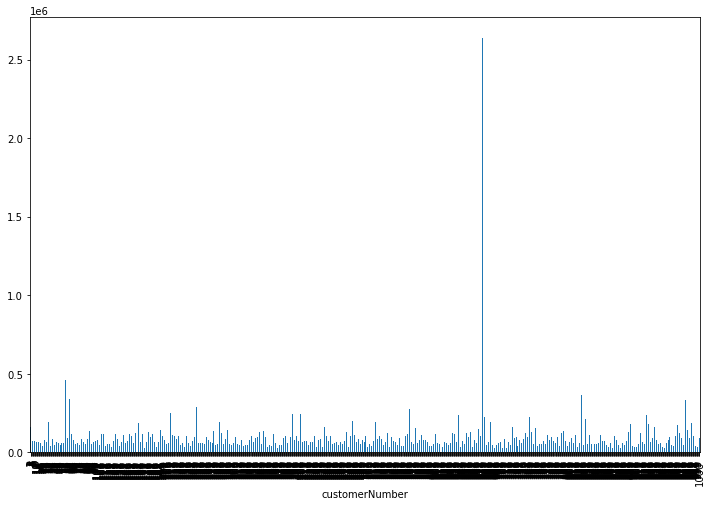

In [32]:
plt.figure(figsize=(12,8))
factura_df.groupby("customerNumber").purchaseAmount.sum().plot(kind="bar")

Where the totals of the purchase amount are grouped by customers. The top ten customers who make the most purchases can be an important piece of information.

In [40]:
factura_df.groupby("customerNumber").articleNumber.nunique().mean()

267.789

This value show us the average number of unqiue items per customer.

In [41]:
factura_df.groupby("customerNumber").articleNumber.nunique()

customerNumber
1       224
2       200
3       299
4       214
5       159
       ... 
996     189
997     250
998     285
999     199
1000    270
Name: articleNumber, Length: 1000, dtype: int64

In [ ]:
You can see number of unqiue items per customer.

In [35]:
factura_df.head()

,customerNumber,purchaseDate,branchNumber,articleNumber,quantity,discountOnRecommendedRetailPrice[%],purchaseAmount
0,557,2021-01-04,19,6013,1.00,0.00,17.24
1,557,2021-01-04,19,6663,2.00,8.37,94.96
2,189,2021-01-04,17,2982,2.00,32.23,59.96
3,490,2021-01-04,19,10658,1.00,25.04,24.05
4,896,2021-01-04,36,14971,3.00,0.00,26.69


# 2. RFM Analysis

In the age of the internet and e-commerce, companies that do not expand their businesses online or utilize digital tools to reach their customers will run into issues like scalability and a lack of digital precsence. An important marketing strategy e-commerce businesses use for analyzing and predicting customer value is customer segmentation. Customer data is used to sort customers into group based on their behaviors and preferences.

**[RFM](https://www.putler.com/rfm-analysis/) (Recency, Frequency, Monetary) Analysis** is a customer segmentation technique for analyzing customer value based on past buying behavior. RFM analysis was first used by the direct mail industry more than four decades ago, yet it is still an effective way to optimize your marketing.
<br>
<br>
Our goal in this Notebook is to cluster the customers in our data set to:
 - Recognize who are our most valuable customers
 - Increase revenue
 - Increase customer retention
 - Learn more about the trends and behaviors of our customers
 - Define customers that are at risk

We will start with **RFM Analysis** and then compliment our findings with predictive analysis using **K-Means Clustering Algorithms.**

- RECENCY (R): Time since last purchase
- FREQUENCY (F): Total number of purchases
- MONETARY VALUE (M): Total monetary value




Benefits of RFM Analysis

- Increased customer retention
- Increased response rate
- Increased conversion rate
- Increased revenue

RFM Analysis answers the following questions:
 - Who are our best customers?
 - Who has the potential to be converted into more profitable customers?
 - Which customers do we need to retain?
 - Which group of customers is most likely to respond to our marketing campaign?

In [42]:
#Finding min and max days
print('Min:{}; Max:{}'.format(min(factura_df.purchaseDate), max(factura_df.purchaseDate)))

Min:2021-01-02; Max:2021-12-31


In [44]:
import datetime
NOW = datetime.datetime(2023,3,31)

In [51]:
factura_df['purchaseDate'] =  pd.to_datetime(factura_df['purchaseDate'])

In [54]:
#Creating a dataframe (rfm) for rfm analysis
rfm = factura_df.groupby(['customerNumber']).agg({
    'purchaseDate': lambda x: (NOW - x.max()).days,
    'articleNumber': 'count',
    'purchaseAmount': 'sum'})

# Rename the columns 
rfm.rename(columns={'purchaseDate': 'Recency',
                         'articleNumber': 'Frequency',
                         'purchaseAmount': 'MonetaryValue'}, inplace=True)
rfm.head(7)

,Recency,Frequency,MonetaryValue
customerNumber,,,
1,457,465,163038.39
2,457,425,33761.03
3,465,1351,179604.73
4,456,423,72671.85
5,465,436,39094.91
6,456,418,42451.10
7,457,485,70876.08


In [55]:
#Creating 4 division for rfm levels

r_labels = range(4, 0,-1); f_labels = range(1, 5); m_labels = range(1, 5)

r_groups = pd.qcut(rfm['Recency'], q=4, labels=r_labels)

f_groups = pd.qcut(rfm['Frequency'], q=4, labels=f_labels)

m_groups = pd.qcut(rfm['MonetaryValue'], q=4, labels=m_labels)

rfm = rfm.assign(R=r_groups.values, F=f_groups.values, M=m_groups.values)

rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

In [56]:
rfm.head(5)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score
customerNumber,,,,,,,
1,457,465,163038.39,3,1,4,8
2,457,425,33761.03,3,1,1,5
3,465,1351,179604.73,1,4,4,9
4,456,423,72671.85,4,1,3,8
5,465,436,39094.91,1,1,1,3


In [57]:
score_labels = ['Low', 'Middle', 'High', "Top Class"]
score_groups = pd.qcut(rfm.RFM_Score, q = 4, labels = score_labels)
rfm['RFM_Level'] = score_groups.values

rfm.sample(5)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Level
customerNumber,,,,,,,,
160,463,449,71403.35,2,1,3,6,Low
760,464,1243,184761.87,1,4,4,9,High
630,458,435,53184.58,3,1,2,6,Low
597,457,475,37702.54,3,2,1,6,Low
115,476,640,196956.60,1,3,4,8,Middle


In [58]:
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']}).round(1)
print(rfm_level_agg)

          Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Level                                      
Low        463.80    476.60      50874.50   322
Middle     458.90    580.00      72075.60   278
High       458.10    802.70     107826.00   258
Top Class  456.00   1388.50     171344.00   142


# 3. Applying K-Means Clustering

Now that we have our customers segmented into 6 different categories, we can gain further insight into customer behavior by using predictive models in conjuction with out RFM model.
Possible algorithms include **Logistic Regression**, **K-means Clustering**, and **K-nearest Neighbor**. We will go with [K-Means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) since we already have our distinct groups determined. K-means has also been widely used for market segmentation and has the advantage of being simple to implement.

In [59]:
rfm_df=rfm.loc[:,["Recency" , "Frequency", "MonetaryValue"]]
rfm_df.sample(5)

,Recency,Frequency,MonetaryValue
customerNumber,,,
444,463,878,98086.32
116,456,528,53625.72
585,456,1073,112958.59
707,459,763,76288.36
963,455,798,67374.75


C:\Users\Taner\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Taner\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Taner\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

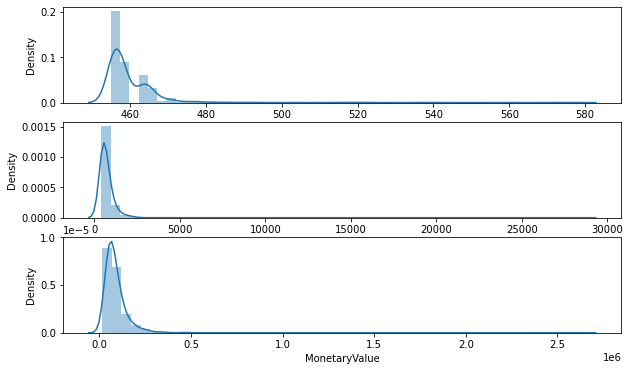

In [62]:
plt.figure(figsize=(10,6))
plt.subplot(3, 1, 1); sns.distplot(rfm_df.Recency)
plt.subplot(3, 1, 2); sns.distplot(rfm_df.Frequency)
plt.subplot(3, 1, 3); sns.distplot(rfm_df.MonetaryValue)
plt.show()

## Using the logarithm method to normalize the values in a column.

You can use the logarithm method to normalize the values in a column.

In [63]:
rfm_log = np.log(rfm_df+1)

In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_log)

rfm_normalized = scaler.transform(rfm_log)

rfm_normalized = pd.DataFrame(data=rfm_normalized, index=rfm_df.index, columns=rfm_df.columns)

In [65]:
rfm_normalized.sample(5)

,Recency,Frequency,MonetaryValue
customerNumber,,,
138,-0.52,-0.59,-0.42
417,-0.52,-0.77,-0.85
978,-0.52,-0.94,-1.98
354,-0.65,1.28,0.68
949,-0.52,-0.03,2.67


In [66]:
rfm_normalized2=rfm_normalized.copy()

In [68]:
rfm_normalized.agg(["mean", "std"]).round()

,Recency,Frequency,MonetaryValue
mean,0.00,0.00,-0.00
std,1.00,1.00,1.00


C:\Users\Taner\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Taner\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Taner\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

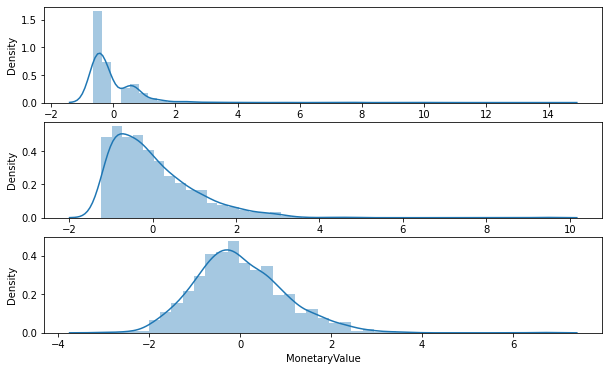

In [69]:
plt.figure(figsize=(10,6))
plt.subplot(3, 1, 1); sns.distplot(rfm_normalized.Recency)
plt.subplot(3, 1, 2); sns.distplot(rfm_normalized.Frequency)
plt.subplot(3, 1, 3); sns.distplot(rfm_normalized.MonetaryValue)
plt.show()

## K-Means Implementation

For k-means, you have to set k to the number of clusters you want, but figuring out how many clusters is not obvious from the beginning. We will try different cluster numbers and check their silhouette coefficient. The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar).

Note: K-means is sensitive to initializations because they are critical to qualifty of optima found. Thus, we will use smart initialization called "Elbow Method".

### Define the Optimal Number of Clusters

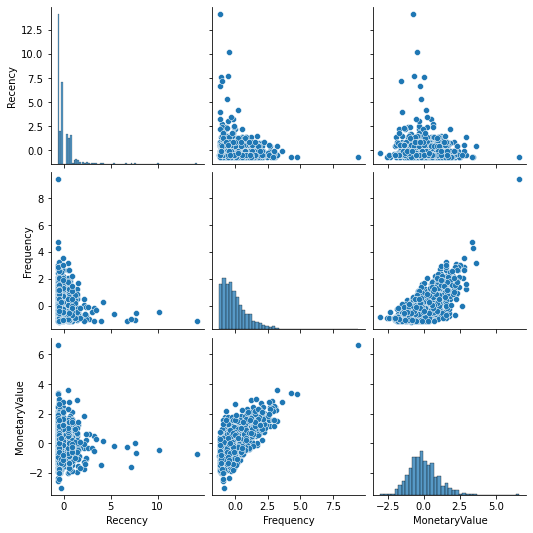

In [70]:
sns.pairplot(rfm_normalized)

In [71]:
from sklearn.cluster import KMeans
sse={}
for k in range(1,15):
    kmeans = KMeans(n_clusters=k, random_state=101)
    kmeans.fit(rfm_normalized)
    sse[k] = kmeans.inertia_

C:\Users\Taner\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


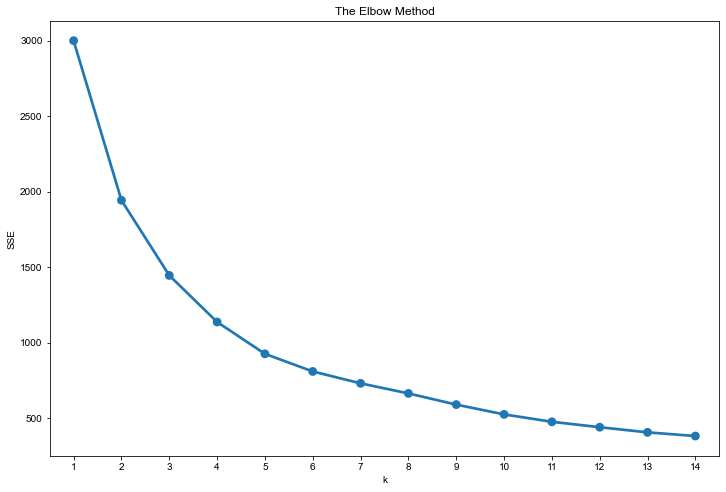

In [72]:
plt.figure(figsize=(12,8))
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
sns.set_style("darkgrid")
plt.show()

In [73]:
from pyclustertend import hopkins
hopkins(rfm_normalized, rfm_normalized.shape[0])

0.03329859161630722

A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

In [74]:
from sklearn.metrics import silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_normalized)
    
    cluster_labels = kmeans.labels_
    
    
    silhouette_avg = silhouette_score(rfm_normalized, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.40412676426962524
For n_clusters=3, the silhouette score is 0.4217605845282431
For n_clusters=4, the silhouette score is 0.31246030933605584
For n_clusters=5, the silhouette score is 0.31606184908722706
For n_clusters=6, the silhouette score is 0.28563629025436366
For n_clusters=7, the silhouette score is 0.2799600116829452
For n_clusters=8, the silhouette score is 0.282870463732882


### Model Fitting

The K-Means Algorithm must be fitted to the optimum number of clusters we have determined.

In [83]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(rfm_normalized)
y_kmeans = kmeans.predict(rfm_normalized)

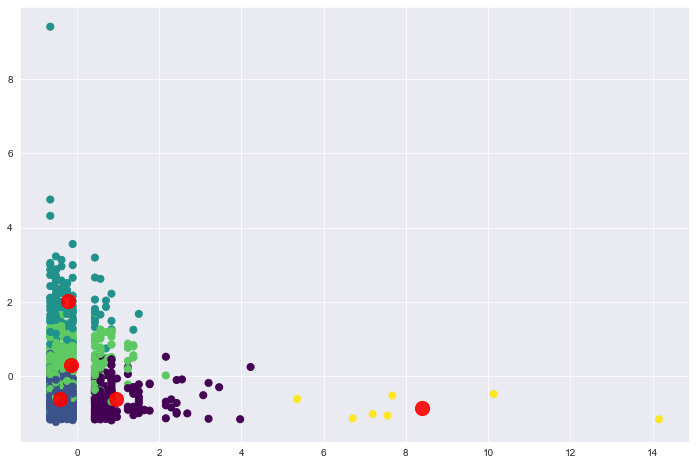

In [84]:
plt.figure(figsize=(12,8))
plt.scatter(rfm_normalized.iloc[:, 0], rfm_normalized.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.9);

In [95]:
cluster_labels = kmeans.labels_
rfm_k5 = rfm.assign(Cluster=cluster_labels)
rfm_k5.sample(35)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Level,Cluster
customerNumber,,,,,,,,,
703,458,444,64785.89,3,1,2,6,Low,1
620,458,571,82185.83,3,2,3,8,Middle,3
637,456,684,67667.94,4,3,2,9,High,3
588,466,392,79557.93,1,1,3,5,Low,0
650,455,466,64112.12,4,1,2,7,Middle,1
402,456,548,90087.41,4,2,3,9,High,3
189,465,417,35237.15,1,1,1,3,Low,0
933,464,810,162494.67,1,4,4,9,High,3
317,456,532,75268.30,4,2,3,9,High,1


In [86]:
grouped = rfm_k5.groupby(['Cluster'])
avg_df=grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)
avg_df

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0        466.90    503.50      56291.30   176
1        456.70    502.50      52649.30   349
2        458.20   1714.70     216881.00   110
3        458.70    735.30     100642.80   358
4        526.60    451.90      57088.70     7

<AxesSubplot:xlabel='Cluster', ylabel='None-None'>

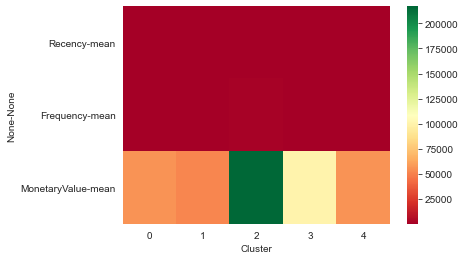

In [87]:
sns.heatmap(avg_df.iloc[:,:-1].T, cmap="RdYlGn")

In [89]:
def rfm_level(df):
    if df['RFM_Score'] >= 11:
        return 'Platinum'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 11)):
      return "Gold"
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 8)):
        return 'Bronze'
    else:
        return 'Silver'

rfm_k5['RFM_Segment'] = rfm_k5.apply(rfm_level, axis=1)

In [99]:
print(rfm_k5.sample(19))

                Recency  Frequency  MonetaryValue  R  F  M  RFM_Score  \
customerNumber                                                          
780                 464        466       56876.49  1  1  2          4   
165                 456        590       68352.86  4  3  2          9   
938                 464        516       74580.17  1  2  3          6   
117                 456        527      147090.50  4  2  4         10   
175                 456        667       36894.79  4  3  1          8   
904                 455       1149      164481.77  4  4  4         12   
268                 457        487       40801.31  3  2  1          6   
502                 456        422       52440.92  4  1  2          7   
398                 455        534      104594.59  4  2  4         10   
224                 459        609       73757.70  2  3  3          8   
599                 456        835      140626.92  4  4  4         12   
98                  456        639       73608.19  

In [100]:
cluster3= rfm_k5[(rfm_k5["RFM_Level"]=="High") & (rfm_k5.Cluster==3)].Recency.count()/rfm_k5[rfm_k5.Cluster==3].Recency.count()
cluster0= rfm_k5[(rfm_k5["RFM_Level"]=="Low") & (rfm_k5.Cluster==0)].Recency.count()/rfm_k5[rfm_k5.Cluster==0].Recency.count()
cluster2= rfm_k5[(rfm_k5["RFM_Level"]=="Top Class") & (rfm_k5.Cluster==2)].Recency.count()/rfm_k5[rfm_k5.Cluster==2].Recency.count()
cluster1= rfm_k5[(rfm_k5["RFM_Level"]=="Middle") & (rfm_k5.Cluster==1)].Recency.count()/rfm_k5[rfm_k5.Cluster==1].Recency.count()

print("clustering success for cluster0 is {:.2f} \n clustering success for cluster1 is {:.2f}\n clustering success for cluster2 is {:.2f}\n clustering success for cluster3 is {:.2f}".format(cluster0, cluster1, cluster2, cluster3))

clustering success for cluster0 is 0.95 
 clustering success for cluster1 is 0.49
 clustering success for cluster2 is 0.64
 clustering success for cluster3 is 0.51


In [67]:
factura_df.head()

,customerNumber,purchaseDate,branchNumber,articleNumber,quantity,discountOnRecommendedRetailPrice[%],purchaseAmount
0,557,2021-01-04,19,6013,1.00,0.00,17.24
1,557,2021-01-04,19,6663,2.00,8.37,94.96
2,189,2021-01-04,17,2982,2.00,32.23,59.96
3,490,2021-01-04,19,10658,1.00,25.04,24.05
4,896,2021-01-04,36,14971,3.00,0.00,26.69
